# Proyecto Properatio: Creación y evaluación de model predictivo

Creacion de un modelo capaz de predecir valores en USD de propiedades tipo Oficinas y Locales Comerciales en CABA Argentina <br><br>
Creado por: Adriana Villalobos

## 1. Importación de librerías y Carga del dataset

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import mlflow.sklearn

In [90]:
import os
from pathlib import Path

print("Actual directorio de trabajo:", os.getcwd())

# Configuro el directorio para no tener /mlruns dentro de los notebooks
current_dir = Path.cwd()
if current_dir.name == "notebooks":
    os.chdir(current_dir.parent)

print("Nuevo directorio de trabajo:", os.getcwd())

Actual directorio de trabajo: /Users/cosmos/Adri/Developer/DataScience/Clases y Consignas/Proyecto Final
Nuevo directorio de trabajo: /Users/cosmos/Adri/Developer/DataScience/Clases y Consignas/Proyecto Final


In [91]:
df = pd.read_csv('data/data_cleaned.csv', sep=",")
df.head()

,Unnamed: 0,neighborhood,rooms,bathrooms,surface_covered,property_type,operation_type,price_usd,price_per_m2,bathrooms_missing,rooms_missing
0,5726,Once,2.0,1.0,20.0,Oficina,Venta,32000.000000,1600.0,0,1
1,5727,Flores,2.0,1.0,32.0,Oficina,Alquiler,279.720280,9.0,0,1
2,5728,Flores,2.0,1.0,46.0,Oficina,Alquiler,349.650350,8.0,0,1
3,5729,Palermo,2.0,2.0,70.0,Oficina,Alquiler,1258.741259,18.0,0,1
4,5731,Tribunales,2.0,1.0,40.0,Oficina,Venta,89000.000000,2225.0,0,1


In [92]:
df['property_type'].value_counts()

property_type
Oficina            10061
Local comercial     9770
Name: count, dtype: int64

In [ ]:
# Acoto el dataset a un solo tipo de propiedad basado en las conclusiones del notebook 02_Model_comparisson
t = 'Alquiler'
p =  'Oficina'
df = df[(df['operation_type'] == t) & (df['property_type'] == p)]
df = df.drop(columns=['operation_type', 'property_type'])

In [94]:
df.shape

(10061, 10)

In [95]:
# Incluyo mlflow para trackear el desempeño de diferentes opciones a lo largo del proceso

mlflow.set_tracking_uri(f"file://{os.getcwd()}/mlruns")
mlflow.set_experiment(experiment_name="Proyecto_Properatio_RF_regressor")

2025/11/12 20:18:48 INFO mlflow.tracking.fluent: Experiment with name 'Proyecto_Properatio_RF_regressor' does not exist. Creating a new experiment.


<Experiment: artifact_location=('file:///Users/cosmos/Adri/Developer/DataScience/Clases y Consignas/Proyecto '
 'Final/mlruns/735040205376143081'), creation_time=1762989528764, experiment_id='735040205376143081', last_update_time=1762989528764, lifecycle_stage='active', name='Proyecto_Properatio_RF_regressor', tags={}>

### 1.1 LabelEncoder para variables categóricas

La variable del barrio se va a pasar por LabelEncoder, el método elegido tras la comparativa realizada en el notebook/02_Models_comparisson.ipynb

In [96]:
from sklearn.preprocessing import LabelEncoder

In [97]:
le_neighborhood = LabelEncoder()
df['neighborhood'] = le_neighborhood.fit_transform(df['neighborhood'])
df.drop(columns=['neighborhood'], inplace=True)

with open('models/le_neighborhood.pkl', 'wb') as f:
  pickle.dump(le_neighborhood, f)

In [98]:
le_operation = LabelEncoder()
df['operation_type'] = le_operation.fit_transform(df['operation_type'])
df.drop(columns=['operation_type'], inplace=True)

with open('models/le_operation_type.pkl', 'wb') as f:
  pickle.dump(le_operation, f)

### 1.2. Transformación de variables numéricas con standardScaler

In [99]:

from sklearn.preprocessing import StandardScaler

numericas = ['rooms', 'bathrooms', 'surface_covered']
scalers = {}
for col in numericas:
    scaler = StandardScaler()
    df[col] = scaler.fit_transform(df[[col]])
    scalers[col] = scaler

# Guardo el scaler para usar en producción
with open("models/scalers.pkl", "wb") as f:
    pickle.dump(scalers, f)

### 1.3 Elimino columnas usadas como flag que no serán usadas en producción

In [100]:
# Elimino filas con valores faltantes en las columnas relevantes
df = df.drop(columns=['rooms_missing', 'bathrooms_missing'])

## 2. Separación de Tr/Ts

In [101]:
X_reg = df.drop(columns=['price_usd', 'price_per_m2'])
y_reg = df['price_per_m2']

Para medir el rendimiento según el porcentaje asignado a test, lo guardo como parámetro de mlFlow. <br>
Se eligió 0.2 tras comparar los resultados de 0.3 y 0.2 en 02_Model_comparisson.ipynb

In [102]:
TEST_SIZE = 0.2
RANDOM_STATE = 42
mlflow.log_param("Tamaño de Test", TEST_SIZE)
mlflow.log_param("Random state", RANDOM_STATE)

42

In [103]:
from sklearn.model_selection import train_test_split

Por la alta varianza de los precios, transformaremos el target con log(x +1)

In [104]:
# Transformación del target para RandomForest Regressor

y_log = np.log1p(y_reg)

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X_reg, y_log, test_size=TEST_SIZE, random_state=RANDOM_STATE)

## 3. Creación de modelo con RF + hypertuning (usando grid search)

In [106]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor 

In [107]:
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error, mean_squared_error, make_scorer

In [108]:
resultados = []

# Función custom para RMSE
def rmse_exp(y_true, y_pred):
    # Aplica la transformación inversa: exp(x) - 1
    y_true_orig = np.expm1(y_true)
    y_pred_orig = np.expm1(y_pred)
    # Calcula el RMSE sobre la escala original
    return root_mean_squared_error(y_true_orig, y_pred_orig)

# Creo el custom scorer para GridSearch
scorer_rmse_custom = make_scorer(rmse_exp, greater_is_better=False) # False para minimizar el error

# Definición del modelo base
rf = RandomForestRegressor(random_state=RANDOM_STATE)


# Definición del espacio de hiperparámetros
param_grid = {
    'n_estimators': [200, 500, 1000],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Configuración del GridSearch
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring=scorer_rmse_custom
)

# Entrenamiento en el target log-transformado
grid_search.fit(X_train, y_train)

# Predicciones (aún en escala logarítmica)
y_pred = grid_search.predict(X_test)

# Resultados en escala original
resultados.append({
            'Modelo': 'RandomForest',
            'R2': r2_score(y_test, y_pred),
            'mse' : mean_squared_error(np.expm1(y_test), np.expm1(y_pred)),
            'rmse': root_mean_squared_error(np.expm1(y_test), np.expm1(y_pred)),
            'mae': mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))
        })

mlflow.log_metric("RandomForest - Mean Squared Error", resultados[0]['mse'])
mlflow.log_metric("RandomForest - R2", resultados[0]['R2'])
mlflow.log_metric("RandomForest - Root Mean Squared Error", resultados[0]['rmse'])
mlflow.log_metric("RandomForest - Mean Absolute Error", resultados[0]['mae'])

print("Mejores parámetros ", grid_search.best_params_)
print(f"R² real: {resultados[0]['R2']:.4f}")
print(f"RMSE (USD): {resultados[0]['rmse']:,.0f}")
print(f"MSE (USD): {resultados[0]['mse']:,.0f}")
print(f"MAE (USD): {resultados[0]['mae']:,.0f}")


/Users/cosmos/Adri/Developer/DataScience/Clases y Consignas/Proyecto Final/.venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejores parámetros  {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
R² real: 0.2703
RMSE (USD): 1,702
MSE (USD): 2,895,465
MAE (USD): 865


In [109]:
best_model = grid_search.best_estimator_

## 4. Visualizaciones

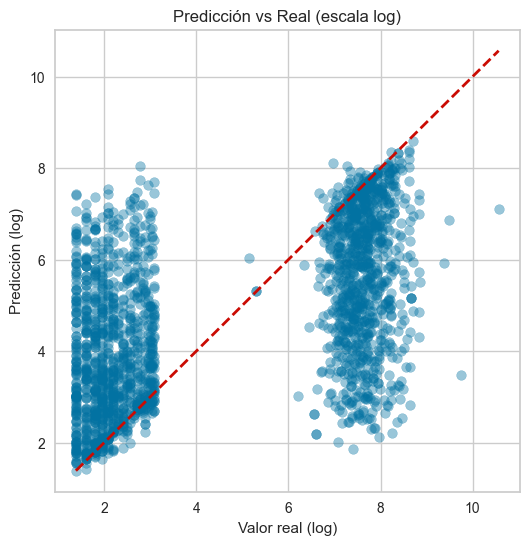

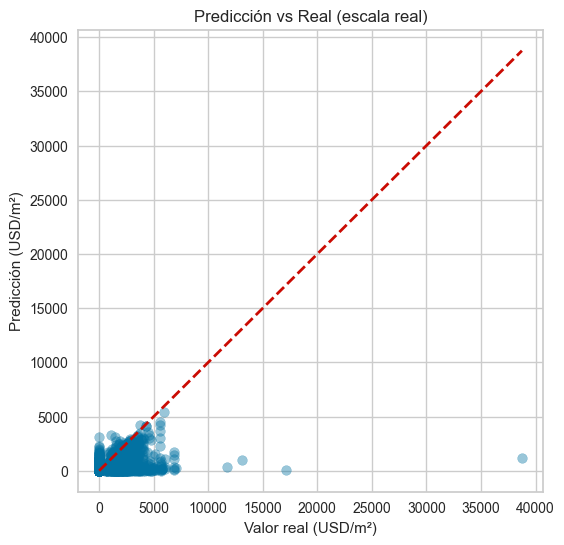

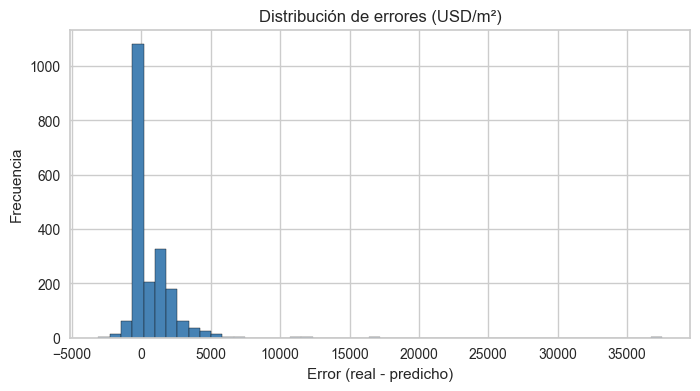

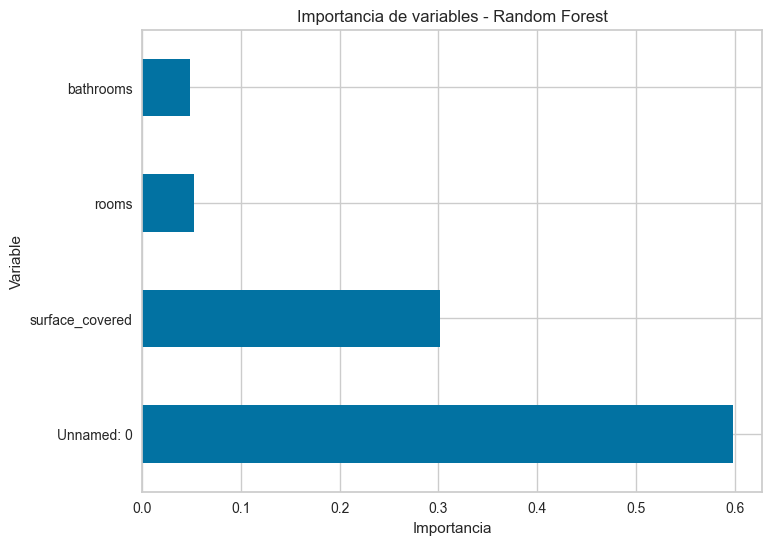

In [110]:

# Predicciones
y_pred_log = best_model.predict(X_test)
y_true_log = y_test

# En log (como entrenó el modelo)
plt.figure(figsize=(6,6))
plt.scatter(y_true_log, y_pred_log, alpha=0.4)
plt.plot([y_true_log.min(), y_true_log.max()],
         [y_true_log.min(), y_true_log.max()],
         'r--', lw=2)
plt.xlabel("Valor real (log)")
plt.ylabel("Predicción (log)")
plt.title("Predicción vs Real (escala log)")
plt.show()

# En escala real
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_true_log)

plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.4)
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         'r--', lw=2)
plt.xlabel("Valor real (USD/m²)")
plt.ylabel("Predicción (USD/m²)")
plt.title("Predicción vs Real (escala real)")
plt.show()

# Distribución de errores
errors = y_true - y_pred
plt.figure(figsize=(8,4))
plt.hist(errors, bins=50, color='steelblue', edgecolor='k')
plt.title("Distribución de errores (USD/m²)")
plt.xlabel("Error (real - predicho)")
plt.ylabel("Frecuencia")
plt.show()

# Importancia de variables
importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
importances.nlargest(15).plot(kind='barh', figsize=(8,6))
plt.title("Importancia de variables - Random Forest")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.show()

In [111]:
grid_search

,estimator,RandomForestR...ndom_state=42)
,param_grid,"{'max_depth': [10, 20, ...], 'max_features': ['sqrt', 'log2', ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,scoring,make_scorer(r...hod='predict')
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


/Users/cosmos/Adri/Developer/DataScience/Clases y Consignas/Proyecto Final/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


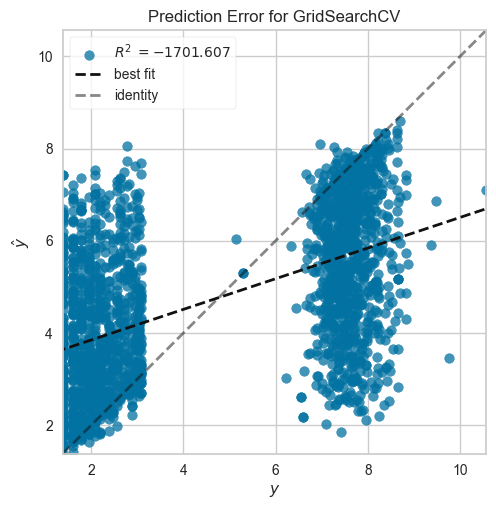

<Axes: title={'center': 'Prediction Error for GridSearchCV'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [112]:
from yellowbrick.regressor import PredictionError

vis_pred_err = PredictionError(grid_search)

vis_pred_err.fit(X_train, y_train)  # Fiteamos los datos al visualizador
vis_pred_err.score(X_test, y_test)  # Calculamos las métricas para test
vis_pred_err.show()                 # Visualizamos!

/Users/cosmos/Adri/Developer/DataScience/Clases y Consignas/Proyecto Final/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


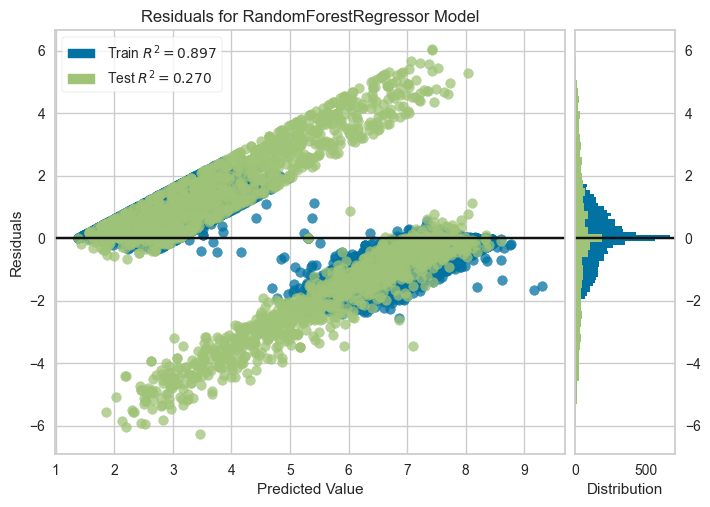

<Axes: title={'center': 'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [113]:
from yellowbrick.regressor import ResidualsPlot

# ojo: poner best_estimator_
vis_res = ResidualsPlot(best_model)


# Copy-paste de la doc oficial: 
vis_res.fit(X_train, y_train)  # Fiteamos los datos al visualizador
vis_res.score(X_test, y_test)  # Calculamos las métricas para test
vis_res.show()                 # Visualizamos!

## 5. Guardado de columnas y el modelo

In [114]:
ohe = list(X_train.columns)  # X_train solo con features, sin price_usd ni price_per_m2

# Guardo las columnas para usar en producción
with open('models/ohe_columns.pkl', 'wb') as f:
    pickle.dump(ohe, f)


In [115]:
# Guardar en el disco

with open('models/model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

## 6. Conclusiones

A lo largo del proyecto se buscó construir un modelo capaz de estimar el valor de mercado del metro cuadrado en propiedades de tipo Oficina y Local comercial en la Ciudad de Buenos Aires, utilizando información estructurada y categórica disponible en el dataset original.

El proceso incluyó una limpieza exhaustiva, imputación de valores faltantes, transformación logarítmica del precio para reducir asimetrías y una codificación diferenciada según el tipo de modelo (OneHotEncoder para modelos lineales y LabelEncoder<sup>*</sup> para Random Forest).

Durante la experimentación, se probaron distintas combinaciones de tipo de propiedad y tipo de operación (Venta y Alquiler), evaluando dos familias de modelos: Regresión Lineal y Random Forest Regressor.

La validación cruzada (K-Fold) mostró que el modelo Random Forest aplicado a Oficinas en alquiler fue el más estable y con mejor capacidad predictiva promedio:

- R² promedio: 0.936 ± 0.004

- MAE promedio: ≈ 2.500 USD/m²

Estos resultados reflejan que el modelo captura con solidez las relaciones estructurales entre variables, con baja varianza entre pliegues. Sin embargo, al evaluarlo sobre un conjunto de test independiente, el rendimiento real descendió a R² ≈ 0.58, con MAE ≈ 11.900 USD/m² y RMSE ≈ 23.200 USD/m².

La comparación entre RMSE y MAE es particularmente reveladora: el RMSE, al penalizar con mayor peso los errores grandes, evidencia la presencia de outliers con valores extremos que afectan el rendimiento general. Esto sugiere que, aunque el modelo logra predecir correctamente la mayoría de los casos, aún presenta dificultades para estimar propiedades con precios atípicos —especialmente aquellas en zonas premium como Puerto Madero, Catalinas o con superficies muy fuera del rango medio—.

El análisis de importancia de variables respalda esta interpretación: las características más influyentes son el barrio y la superficie cubierta, seguidas a distancia por la cantidad de ambientes y baños. Esto confirma el peso central de la ubicación y el tamaño del inmueble en la determinación del valor, coherente con la lógica del mercado inmobiliario porteño.

En términos prácticos, esto implica que el modelo es útil como herramienta de referencia para estimaciones iniciales en escenarios de alquiler de oficinas, pero no sustituye la valoración profesional.

En síntesis, el modelo cumple con su propósito académico y experimental: captura patrones relevantes, cuantifica su incertidumbre y ofrece un punto de partida sólido para la predicción de precios en el mercado inmobiliario.

(*) Mas tarde se cambió el uso del LabelEncoder a OHE para la columna de Barrios para ver si capturaba mejor el precio en los barrios caros y en los económicos. 